In [2]:
# Imports :
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [3]:
df = pd.read_table('horse_data23.txt')

class_names = np.unique(df['lameLeg'])

y = df['lameLeg']

c  =  np.array(pd.get_dummies(y)) @ np.array([1,2,3,4,5])

df.head()

,experiment,horse,lameLeg,lameSide,lameForeHind,A,S,W,pc1,pc2,pc3,pc4
1,1,B1,none,none,none,-0.002304,-4.513454,-0.013884,0.121519,0.031750,0.046953,0.144889
2,1,B1,none,none,none,-0.045322,-4.453982,-0.012962,0.125487,-0.001296,0.043845,0.125972
3,1,B1,none,none,none,-0.010038,-6.086829,-0.008943,0.122509,-0.096972,0.007267,0.034485
4,1,B1,none,none,none,-0.001488,-4.520627,-0.009451,0.115689,0.129737,0.029682,0.128926
16,1,B2,none,none,none,-0.126048,-5.303123,0.002075,0.114835,-0.032392,0.018564,-0.118194


In [4]:
# class imbalance
print("---------------------")
print("count of each lameness:")
print("---------------------")
print(class_names)
print([sum(c==i+1) for i in range(5)])
print("---------------------")
print("count of each horse:")
print("---------------------")
print(np.unique(df['horse']))
print([(sum(np.unique(df['horse'])[i] == df['horse'])) for i in range(8)])

---------------------
count of each lameness:
---------------------
['left:fore' 'left:hind' 'none' 'right:fore' 'right:hind']
[16, 16, 23, 16, 14]
---------------------
count of each horse:
---------------------
['B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B9']
[13, 13, 10, 13, 9, 9, 9, 9]


# 1. 
*with the data A and W*

In [5]:
X1 = df[['A', 'W']]

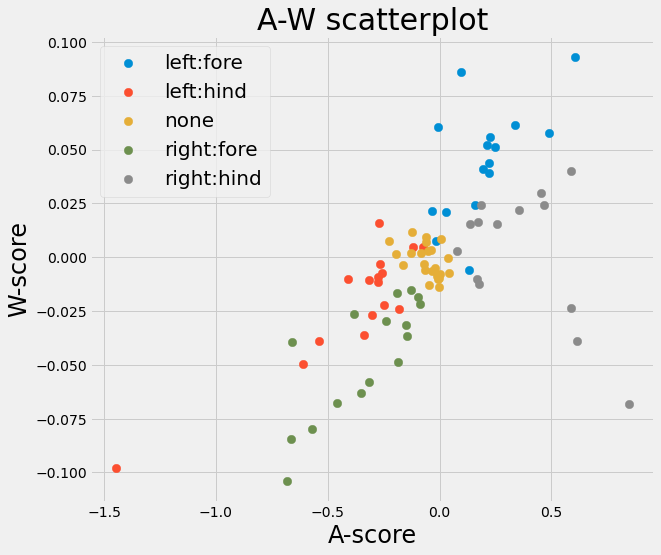

In [6]:
plt.figure(figsize=(9,8))
for i in range(5):
    index = i+1 == c
    plt.scatter(X1['A'][index], X1['W'][index], s = 70, label = class_names[i])

plt.legend(prop = {"size":20})
plt.title('A-W scatterplot', fontsize = 30)
plt.ylabel('W-score', fontsize = 24)
plt.xlabel('A-score', fontsize = 24)
#plt.savefig('picture/scat_1.jpg', bbox_inches="tight")
plt.show()



### **CROSS VALIDATION LOOP**

Pros:
Getting an un-biased accuracy

Cons: 
Variance is diffiult to estimate

In [7]:
# test withh standardization

np.random.seed(0)

n_estimators = [10,50,100,300,300,500,1000]
saved_estimators = np.zeros(8)

print_running_accuracy = False

LogisticModel_accuracy_1 = np.zeros(8)
RandomForest_accuracy_1 = np.zeros(8)
Baseline_accuracy_1 = np.zeros(8)

N_test = np.zeros(8)

# cross-validation loop for each horse
for i in range(8):
    RandomForest_accuracy_inner = np.zeros(7)
    # printing
    print("CV-loop: " + str(i+1)) if print_running_accuracy else print("CV-loop: " + str(i+1), end = '\r') 
    # indexing
    array_inner = np.delete(np.unique(df['horse']),i)
    index_test = df['horse'] == np.unique(df['horse'])[i]
    index_train = df['horse'] != np.unique(df['horse'])[i]
    index_test = index_test.to_numpy()
    index_train = index_train.to_numpy()

    # splitting the data
    X_train, y_train = X1[index_train], c[index_train]
    X_test, y_test = X1[index_test], c[index_test]
    N_test[i], _ = np.shape(X_train)

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # standardization
    mu = np.mean(X_train)
    sd = np.std(X_train)
    X_train = (X_train - mu)/sd
    X_test = (X_test - mu)/sd

    for j in range(7):
        index_test_inner = df['horse'] == array_inner[j]
        index_train_inner = df['horse'] != array_inner[j]

        # splitting the data
        X_train_inner, y_train_inner = X1[index_train_inner], c[index_train_inner]
        X_test_inner, y_test_inner = X1[index_test_inner], c[index_test_inner]
        RandomForestModelInner = RandomForestClassifier(n_estimators=n_estimators[j])
        RandomForestModelInner.fit(X_train_inner, y_train_inner)
        RandomForest_y_predInner = RandomForestModelInner.predict(X_test_inner)
        RandomForest_accuracy_inner[j] = sum(RandomForest_y_predInner == y_test_inner)/len(y_test_inner)

    # baseline
    _, counts = np.unique(y_train, return_counts=True)
    Baseline_y_pred = np.argmax(counts) + 1
    Baseline_accuracy_1[i] =  sum(y_test == Baseline_y_pred)/len(y_test)
    if print_running_accuracy: print("Baseline's accuracy:", Baseline_accuracy_1[i])


    # logistic
    LogisticModel = LogisticRegression()
    LogisticModel.fit(X_train, y_train)
    Logistic_y_pred = LogisticModel.predict(X_test)
    LogisticModel_accuracy_1[i] = sum(Logistic_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("LogisticModel's accuracy:", LogisticModel_accuracy_1[i])

    # randomforest
    RandomForestModel = RandomForestClassifier(n_estimators=n_estimators[np.argmax(RandomForest_accuracy_inner)])
    saved_estimators[i] = n_estimators[np.argmax(RandomForest_accuracy_inner)]
    RandomForestModel.fit(X_train, y_train)
    RandomForest_y_pred = RandomForestModel.predict(X_test)
    RandomForest_accuracy_1[i] = sum(RandomForest_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("RandomForestModel's accuracy:", RandomForest_accuracy_1[i])

    
print("--------------------------------------")
print("The mean accuracy for Baseline: ", np.mean(Baseline_accuracy_1))
print("The mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_1))
print("The mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_1))
print("--------------------------------------")
print("The weighted mean accuracy for Baseline: ", np.mean(Baseline_accuracy_1 * N_test/85))
print("The weighted mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_1*N_test/85))
print("The weighted mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_1*N_test/85))
print("--------------------------------------")
print("Chosen n-estimators in random tree model:")
print(saved_estimators)


--------------------------------------
The mean accuracy for Baseline:  0.24978632478632481
The mean accuracy for LogisticModel:  0.5907051282051281
The mean accuracy for RandomForestModel:  0.7289529914529914
--------------------------------------
The weighted mean accuracy for Baseline:  0.2159627953745601
The weighted mean accuracy for LogisticModel:  0.5171757164404223
The weighted mean accuracy for RandomForestModel:  0.6377765208647561
--------------------------------------
Chosen n-estimators in random tree model:
[ 50.  50. 500. 100. 100. 100. 100. 100.]


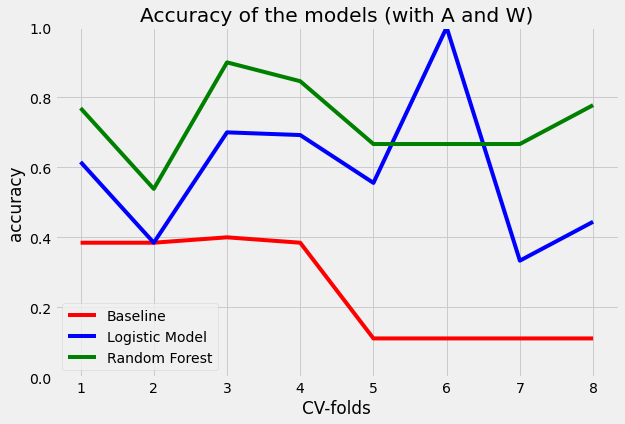

In [8]:
plt.figure(figsize=(9,6))
x = [i+1 for i in range(8)]
plt.plot(x,Baseline_accuracy_1, 'r-', label = "Baseline") #can be 'r--', 'bs', 'g^'
plt.plot(x,LogisticModel_accuracy_1, 'b-', label = "Logistic Model") #can be 'r--', 'bs', 'g^'
plt.plot(x,RandomForest_accuracy_1, 'g-', label = "Random Forest") #can be 'r--', 'bs', 'g^'
plt.ylabel('accuracy')
plt.xlabel('CV-folds')
plt.ylim((0,1))
plt.title('Accuracy of the models (with A and W)')
plt.legend()
plt.savefig('picture/acc_1.jpg', bbox_inches="tight")
plt.show()

In [119]:
# save data to txt
accucary_A_W = pd.DataFrame(np.column_stack((Baseline_accuracy_1, LogisticModel_accuracy_1, RandomForest_accuracy_1)), columns=["Base", "Log", "Rand"])

accucary_A_W.to_csv('data/A_and_W.txt', header=None, index=None, sep=' ', mode='a')
accucary_A_W

,Base,Log,Rand
0,0.384615,0.615385,0.692308
1,0.384615,0.384615,0.538462
2,0.400000,0.700000,1.000000
3,0.384615,0.692308,0.846154
4,0.111111,0.555556,0.666667
5,0.111111,1.000000,0.666667
6,0.111111,0.333333,0.777778
7,0.111111,0.444444,0.888889


### Decision boundary for first model

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

[[-0.07278064  0.06104109]
 [ 0.07313436  0.07766066]
 [ 0.10849019  0.07556194]
 [-0.40661341  0.12322421]]


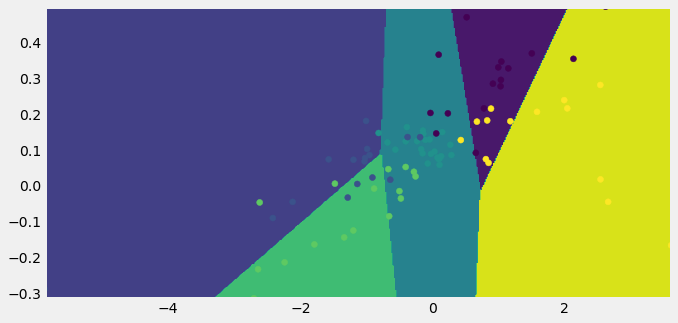

In [12]:
X_test = X1.to_numpy()
X_test = (X_test - np.mean(X_test))/(np.std(X_test))
print(X_test[1:5,:])

x0, x1 = np.meshgrid(
    np.linspace(X_test[:,0].min(), X_test[:,0].max(), 500).reshape(-1, 1),
    np.linspace(X_test[:,1].min(), X_test[:,1].max(), 500).reshape(-1, 1)
)

X_new = np.c_[x0.ravel(), x1.ravel()]
y_pred = LogisticModel.predict(X_new)

name = ["none", "diag_2","diag_1", "none"]

zz = y_pred.reshape(x0.shape)

formatter = plt.FuncFormatter(lambda i, *args: name[int(i)])

#custom_cmap = ListedColormap(["orange", "cyan", "cornflowerblue"])
#custom_cmap = ListedColormap(['#b4a7d6','#93c47d','#fff2cc'])


plt.figure(figsize=(10, 5))
plt.contourf(x0, x1, zz)#), cmap=custom_cmap)
plt.scatter(X_test[:,0], X_test[:,1], c=c)
#plt.colorbar(ticks = [0,1,2,3],format=formatter)
plt.show()

# 2.

*classification with pc3 & pc4*

In [13]:
X2 = df[['pc3', 'pc4']]

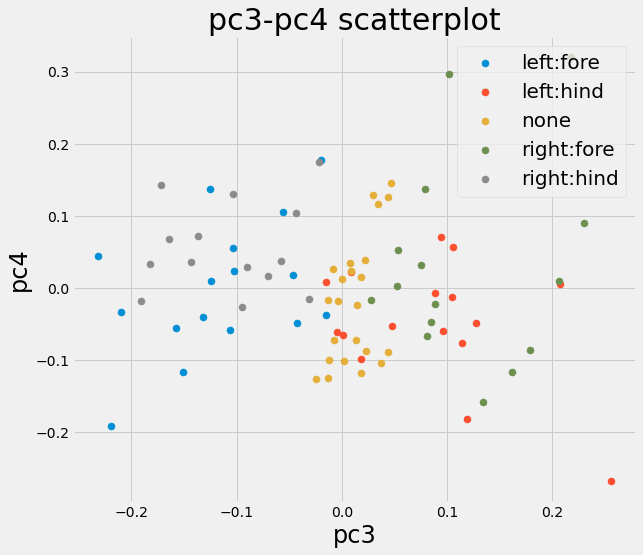

In [14]:
plt.figure(figsize=(9,8))
for i in range(5):
    index = i+1 == c
    plt.scatter(X2['pc3'][index], X2['pc4'][index], s = 50, label = class_names[i])
plt.legend(prop = {"size":20})
plt.title('pc3-pc4 scatterplot', fontsize = 30)
plt.ylabel('pc4', fontsize = 24)
plt.xlabel('pc3', fontsize = 24)
#plt.savefig('picture/scat_2.jpg', bbox_inches="tight")
plt.show()

In [15]:
# test withh standardization

np.random.seed(0)

n_estimators = [10,50,100,300,300,500,1000]
saved_estimators = np.zeros(8)

print_running_accuracy = False

LogisticModel_accuracy_2 = np.zeros(8)
RandomForest_accuracy_2 = np.zeros(8)
Baseline_accuracy_2 = np.zeros(8)

N_test = np.zeros(8)

# cross-validation loop for each horse
for i in range(8):
    RandomForest_accuracy_inner = np.zeros(7)
    # printing
    print("CV-loop: " + str(i+1)) if print_running_accuracy else print("CV-loop: " + str(i+1), end = '\r') 
    # indexing
    array_inner = np.delete(np.unique(df['horse']),i)
    index_test = df['horse'] == np.unique(df['horse'])[i]
    index_train = df['horse'] != np.unique(df['horse'])[i]
    index_test = index_test.to_numpy()
    index_train = index_train.to_numpy()

    # splitting the data
    X_train, y_train = X2[index_train], c[index_train]
    X_test, y_test = X2[index_test], c[index_test]
    N_test[i], _ = np.shape(X_train)

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # standardization
    mu = np.mean(X_train)
    sd = np.std(X_train)
    X_train = (X_train - mu)/sd
    X_test = (X_test - mu)/sd

    for j in range(7):
        index_test_inner = df['horse'] == array_inner[j]
        index_train_inner = df['horse'] != array_inner[j]

        # splitting the data
        X_train_inner, y_train_inner = X2[index_train_inner], c[index_train_inner]
        X_test_inner, y_test_inner = X2[index_test_inner], c[index_test_inner]
        RandomForestModelInner = RandomForestClassifier(n_estimators=n_estimators[j])
        RandomForestModelInner.fit(X_train_inner, y_train_inner)
        RandomForest_y_predInner = RandomForestModelInner.predict(X_test_inner)
        RandomForest_accuracy_inner[j] = sum(RandomForest_y_predInner == y_test_inner)/len(y_test_inner)

    # baseline
    _, counts = np.unique(y_train, return_counts=True)
    Baseline_y_pred = np.argmax(counts) + 1
    Baseline_accuracy_2[i] =  sum(y_test == Baseline_y_pred)/len(y_test)
    if print_running_accuracy: print("Baseline's accuracy:", Baseline_accuracy_2[i])


    # logistic
    LogisticModel = LogisticRegression()
    LogisticModel.fit(X_train, y_train)
    Logistic_y_pred = LogisticModel.predict(X_test)
    LogisticModel_accuracy_2[i] = sum(Logistic_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("LogisticModel's accuracy:", LogisticModel_accuracy_2[i])

    # randomforest
    RandomForestModel = RandomForestClassifier(n_estimators=n_estimators[np.argmax(RandomForest_accuracy_inner)])
    saved_estimators[i] = n_estimators[np.argmax(RandomForest_accuracy_inner)]
    RandomForestModel.fit(X_train, y_train)
    RandomForest_y_pred = RandomForestModel.predict(X_test)
    RandomForest_accuracy_2[i] = sum(RandomForest_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("RandomForestModel's accuracy:", RandomForest_accuracy_2[i])

    
print("--------------------------------------")
print("The mean accuracy for Baseline: ", np.mean(Baseline_accuracy_2))
print("The mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_2))
print("The mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_2))
print("--------------------------------------")
print("The weighted mean accuracy for Baseline: ", np.mean(Baseline_accuracy_2 * N_test/85))
print("The weighted mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_2*N_test/85))
print("The weighted mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_2*N_test/85))
print("--------------------------------------")
print("Chosen n-estimators in random tree model:")
print(saved_estimators)


--------------------------------------
The mean accuracy for Baseline:  0.24978632478632481
The mean accuracy for LogisticModel:  0.49380341880341877
The mean accuracy for RandomForestModel:  0.4228632478632479
--------------------------------------
The weighted mean accuracy for Baseline:  0.2159627953745601
The weighted mean accuracy for LogisticModel:  0.4320387129210659
The weighted mean accuracy for RandomForestModel:  0.36845148315736553
--------------------------------------
Chosen n-estimators in random tree model:
[ 500.  300.   50.  500.  500.  500.   50. 1000.]


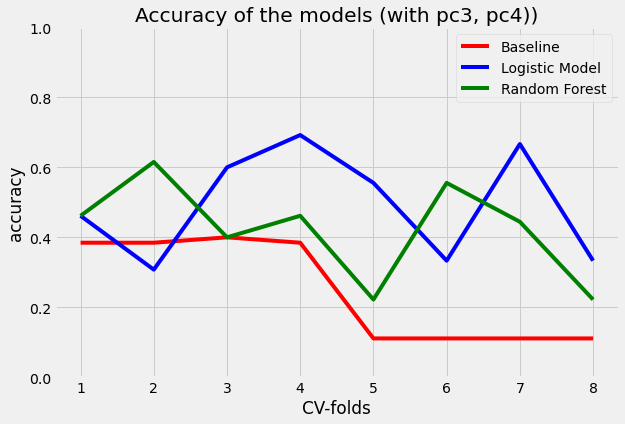

In [16]:
plt.figure(figsize=(9,6))
x = [i+1 for i in range(8)]
plt.plot(x,Baseline_accuracy_2, 'r-', label = "Baseline") #can be 'r--', 'bs', 'g^'
plt.plot(x,LogisticModel_accuracy_2, 'b-', label = "Logistic Model") #can be 'r--', 'bs', 'g^'
plt.plot(x,RandomForest_accuracy_2, 'g-', label = "Random Forest") #can be 'r--', 'bs', 'g^'
plt.ylabel('accuracy')
plt.xlabel('CV-folds')
plt.ylim((0,1))
plt.title('Accuracy of the models (with pc3, pc4))')
plt.legend()
plt.savefig('picture/acc_2.jpg', bbox_inches="tight")
plt.show()

[[ 0.38843502  1.16839413]
 [ 0.0410581   0.29954446]
 [ 0.25392602  1.19645143]
 [ 0.14834355 -1.15044475]]


/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_29844/294507429.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks = [0,1,2,3,4,5],format=formatter)


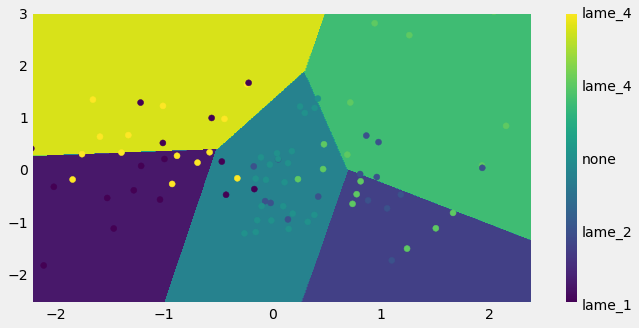

In [26]:
X_test = X2.to_numpy()
X_test = (X_test - np.mean(X_test))/(np.std(X_test))
print(X_test[1:5,:])

x0, x1 = np.meshgrid(
    np.linspace(X_test[:,0].min(), X_test[:,0].max(), 500).reshape(-1, 1),
    np.linspace(X_test[:,1].min(), X_test[:,1].max(), 500).reshape(-1, 1)
)

X_new = np.c_[x0.ravel(), x1.ravel()]
y_pred = LogisticModel.predict(X_new)

name = ["none", "diag_2","diag_1", "none"]

zz = y_pred.reshape(x0.shape)

formatter = plt.FuncFormatter(lambda i, *args: name[int(i)])

#custom_cmap = ListedColormap(["orange", "cyan", "cornflowerblue"])
#custom_cmap = ListedColormap(['#b4a7d6','#93c47d','#fff2cc'])

name = ['1', 'lame_1', 'lame_2', 'none', 'lame_4', 'lame_4']
formatter = plt.FuncFormatter(lambda i, *args: name[int(i)])



plt.figure(figsize=(10, 5))
plt.contourf(x0, x1, zz)#), cmap=custom_cmap)
plt.scatter(X_test[:,0], X_test[:,1], c=c)
plt.colorbar(ticks = [0,1,2,3,4,5],format=formatter)
plt.savefig('picture/dec_boun_11.jpg', bbox_inches="tight")
plt.show()

[[-0.07278064  0.06104109]
 [ 0.07313436  0.07766066]
 [ 0.10849019  0.07556194]
 [-0.40661341  0.12322421]]


/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_29844/3761735006.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks = [0,1,2,3,4,5],format=formatter)


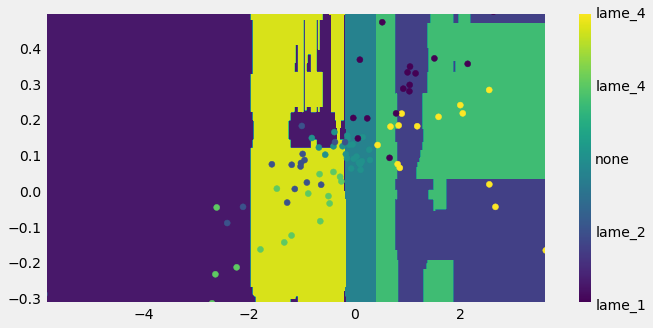

In [28]:
X_test = X1.to_numpy()
X_test = (X_test - np.mean(X_test))/(np.std(X_test))
print(X_test[1:5,:])

x0, x1 = np.meshgrid(
    np.linspace(X_test[:,0].min(), X_test[:,0].max(), 500).reshape(-1, 1),
    np.linspace(X_test[:,1].min(), X_test[:,1].max(), 500).reshape(-1, 1)
)

X_new = np.c_[x0.ravel(), x1.ravel()]
y_pred = RandomForestModel.predict(X_new)

name = ['1', 'lame_1', 'lame_2', 'none', 'lame_4', 'lame_4']

zz = y_pred.reshape(x0.shape)

formatter = plt.FuncFormatter(lambda i, *args: name[int(i)])

#custom_cmap = ListedColormap(["orange", "cyan", "cornflowerblue"])
#custom_cmap = ListedColormap(['#b4a7d6','#93c47d','#fff2cc'])


plt.figure(figsize=(10, 5))
plt.contourf(x0, x1, zz)#), cmap=custom_cmap)
plt.scatter(X_test[:,0], X_test[:,1], c=c)
plt.colorbar(ticks = [0,1,2,3,4,5],format=formatter)
#plt.colorbar(ticks = [0,1,2,3],format=formatter)
plt.savefig('picture/dec_boun_21.jpg', bbox_inches="tight")
plt.show()

# 3.
*classification with S & W & pc3 & pc4*

In [153]:
X3 = df[['S', 'W', 'pc3', 'pc4']]

In [167]:
# test withh standardization

np.random.seed(0)

n_estimators = [10,50,100,300,300,500,1000]
saved_estimators = np.zeros(8)

print_running_accuracy = False

LogisticModel_accuracy_3 = np.zeros(8)
RandomForest_accuracy_3 = np.zeros(8)
Baseline_accuracy_3 = np.zeros(8)

N_test = np.zeros(8)

# cross-validation loop for each horse
for i in range(8):
    RandomForest_accuracy_inner = np.zeros(7)
    # printing
    print("CV-loop: " + str(i+1)) if print_running_accuracy else print("CV-loop: " + str(i+1), end = '\r') 
    # indexing
    array_inner = np.delete(np.unique(df['horse']),i)
    index_test = df['horse'] == np.unique(df['horse'])[i]
    index_train = df['horse'] != np.unique(df['horse'])[i]
    index_test = index_test.to_numpy()
    index_train = index_train.to_numpy()

    # splitting the data
    X_train, y_train = X3[index_train], c[index_train]
    X_test, y_test = X3[index_test], c[index_test]
    N_test[i], _ = np.shape(X_train)

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # standardization
    mu = np.mean(X_train)
    sd = np.std(X_train)
    X_train = (X_train - mu)/sd
    X_test = (X_test - mu)/sd

    for j in range(7):
        index_test_inner = df['horse'] == array_inner[j]
        index_train_inner = df['horse'] != array_inner[j]

        # splitting the data
        X_train_inner, y_train_inner = X3[index_train_inner], c[index_train_inner]
        X_test_inner, y_test_inner = X3[index_test_inner], c[index_test_inner]
        RandomForestModelInner = RandomForestClassifier(n_estimators=n_estimators[j])
        RandomForestModelInner.fit(X_train_inner, y_train_inner)
        RandomForest_y_predInner = RandomForestModelInner.predict(X_test_inner)
        RandomForest_accuracy_inner[j] = sum(RandomForest_y_predInner == y_test_inner)/len(y_test_inner)

    # baseline
    _, counts = np.unique(y_train, return_counts=True)
    Baseline_y_pred = np.argmax(counts) + 1
    Baseline_accuracy_3[i] =  sum(y_test == Baseline_y_pred)/len(y_test)
    if print_running_accuracy: print("Baseline's accuracy:", Baseline_accuracy_3[i])


    # logistic
    LogisticModel = LogisticRegression()
    LogisticModel.fit(X_train, y_train)
    Logistic_y_pred = LogisticModel.predict(X_test)
    LogisticModel_accuracy_3[i] = sum(Logistic_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("LogisticModel's accuracy:", LogisticModel_accuracy_3[i])

    # randomforest
    RandomForestModel = RandomForestClassifier(n_estimators=n_estimators[np.argmax(RandomForest_accuracy_inner)])
    saved_estimators[i] = n_estimators[np.argmax(RandomForest_accuracy_inner)]
    RandomForestModel.fit(X_train, y_train)
    RandomForest_y_pred = RandomForestModel.predict(X_test)
    RandomForest_accuracy_3[i] = sum(RandomForest_y_pred == y_test)/len(y_test)
    if print_running_accuracy: print("RandomForestModel's accuracy:", RandomForest_accuracy_3[i])

    
print("--------------------------------------")
print("The mean accuracy for Baseline: ", np.mean(Baseline_accuracy_3))
print("The mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_3))
print("The mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_3))
print("--------------------------------------")
print("The weighted mean accuracy for Baseline: ", np.mean(Baseline_accuracy_3 * N_test/85))
print("The weighted mean accuracy for LogisticModel: ", np.mean(LogisticModel_accuracy_3*N_test/85))
print("The weighted mean accuracy for RandomForestModel: ", np.mean(RandomForest_accuracy_3*N_test/85))
print("--------------------------------------")
print("Chosen n-estimators in random tree model:")
print(saved_estimators)

--------------------------------------
The mean accuracy for Baseline:  0.24978632478632481
The mean accuracy for LogisticModel:  0.5127136752136752
The mean accuracy for RandomForestModel:  0.680448717948718
--------------------------------------
The weighted mean accuracy for Baseline:  0.2159627953745601
The weighted mean accuracy for LogisticModel:  0.44653720462544
The weighted mean accuracy for RandomForestModel:  0.5951546003016592
--------------------------------------
Chosen n-estimators in random tree model:
[ 500.  500.  500.  500.  500.  500.   50. 1000.]


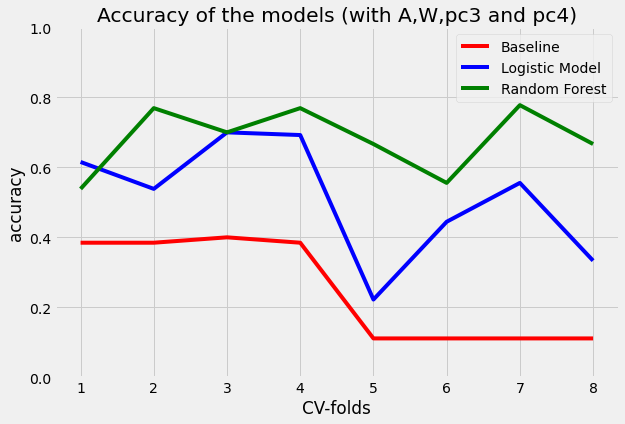

In [168]:
plt.figure(figsize=(9,6))
x = [i+1 for i in range(8)]
plt.plot(x,Baseline_accuracy_3, 'r-', label = "Baseline") #can be 'r--', 'bs', 'g^'
plt.plot(x,LogisticModel_accuracy_3, 'b-', label = "Logistic Model") #can be 'r--', 'bs', 'g^'
plt.plot(x,RandomForest_accuracy_3, 'g-', label = "Random Forest") #can be 'r--', 'bs', 'g^'
plt.ylabel('accuracy')
plt.xlabel('CV-folds')
plt.ylim((0,1))
plt.title('Accuracy of the models (with A,W,pc3 and pc4)')
plt.legend()
plt.savefig('picture/acc_3.jpg', bbox_inches="tight")
plt.show()

In [148]:
# save data to txt
accucary_A_W = pd.DataFrame(np.column_stack((Baseline_accuracy_1, LogisticModel_accuracy_1, RandomForest_accuracy_1,Baseline_accuracy_2, LogisticModel_accuracy_2, RandomForest_accuracy_2,Baseline_accuracy_3, LogisticModel_accuracy_3, RandomForest_accuracy_3)), columns=["Base1", "Log1", "Rand1","Base2", "Log2", "Rand2","Base3", "Log3", "Rand3"])

accucary_A_W.to_csv('data/accuracy_of_models.csv')#, header=None, index=None, sep=' ', mode='a')
accucary_A_W

,Base1,Log1,Rand1,Base2,Log2,Rand2,Base3,Log3,Rand3
0,0.384615,0.615385,0.769231,0.384615,0.461538,0.538462,0.384615,0.615385,0.538462
1,0.384615,0.384615,0.538462,0.384615,0.307692,0.615385,0.384615,0.538462,0.692308
2,0.400000,0.700000,0.900000,0.400000,0.600000,0.300000,0.400000,0.700000,0.600000
3,0.384615,0.692308,0.846154,0.384615,0.692308,0.384615,0.384615,0.692308,0.769231
4,0.111111,0.555556,0.666667,0.111111,0.555556,0.333333,0.111111,0.222222,0.666667
5,0.111111,1.000000,0.666667,0.111111,0.333333,0.555556,0.111111,0.444444,0.555556
6,0.111111,0.333333,0.666667,0.111111,0.666667,0.555556,0.111111,0.555556,0.777778
7,0.111111,0.444444,0.777778,0.111111,0.333333,0.333333,0.111111,0.333333,0.666667


In [175]:
accucary_A_W.mean()

Base1    0.249786
Log1     0.590705
Rand1    0.728953
Base2    0.249786
Log2     0.493803
Rand2    0.452030
Base3    0.249786
Log3     0.512714
Rand3    0.658333
dtype: float64